In [ ]:
import torch
from langevin_sampling.samplers import LangevinDynamics, MetropolisAdjustedLangevin
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import copy
from autoimpute.imputations import MiceImputer, MultipleImputer, SingleImputer
import pandas as pd
import dill
from tqdm import tqdm
from mdfeature.KramersRateEvaluator import KramersRateEvaluator
np.random.seed(10)
torch.manual_seed(10)

device = torch.device('cpu')
torch.set_default_tensor_type('torch.FloatTensor')

def double_well_negative_log(x):
    h = 1.75
    c = 2
    return -(1/4)*(x**2)*(h**4) + (1/2)*(c**2)*(x**4)

In [ ]:
#dill.dump(est_samples, file = open("double_well_samples.pickle", "wb"))
est_samples = dill.load(open("double_well_samples.pickle", "rb"))


In [ ]:
x = torch.randn([1], requires_grad=True, device=device)
max_itr = int(3e6)
burn_in_samples = 50

MALA = True

if MALA is True:
    sampler = MetropolisAdjustedLangevin(
        x,
        double_well_negative_log,
        lr=1e-1,
        lr_final=4e-2,
        max_itr=max_itr,
        device=device
    )
else:
    sampler = LangevinDynamics(
        x,
        double_well_negative_log,
        lr=0.5,
        lr_final=1e-2,
        max_itr=max_itr,
        device=device
    )

hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = sampler.sample()
    loss_log.append(loss)
    hist_samples.append(est.cpu().numpy())
        
est_samples = np.array(hist_samples).flatten()[burn_in_samples:]

fig = plt.figure(dpi=150, figsize=(9, 4))
plt.hist(est_samples, bins=200, density=True)
plt.xlabel('x coordinate')
plt.ylabel('Probability Density')
plt.show()
plt.tight_layout()
plt.show()

In [ ]:
import scipy.interpolate as interpolate

def free_energy_estimate(samples):
    
    # histogram
    counts, coordinate = np.histogram(samples, bins=200)
    robust_counts = counts[np.where(counts>50)]
    robust_coordinates = coordinate[np.where(counts>50)]
    
    # log noraml
    normalised_counts = robust_counts / np.sum(counts)
    with np.errstate(divide='ignore'):
        free_energy = - np.log(normalised_counts)
    
    # nan imputation
    for index, energy in enumerate(free_energy):
        if energy == np.inf or energy == -np.inf:
            free_energy[index] = np.nan
            
    df = pd.DataFrame({'CV':robust_coordinates, 'F':free_energy})
    si = MiceImputer(return_list=True, strategy={"F": "interpolate"},n=1)
    output = si.fit_transform(df)[0][1]
    
    # smoothing
    
    dx = 0.001
    sigma = 0.03
    interpolated_F = interpolate.interp1d(output.CV, output.F, fill_value='extrapolate')
    smoothed_range = np.arange(min(output.CV), max(output.CV), dx)
    sampled_F = interpolated_F(smoothed_range)

    gx = np.arange(-3 * sigma, 3 * sigma, dx)
    gaussian = (1/(np.sqrt(2*np.pi *sigma**2))) * np.exp(-(gx / sigma) ** 2 / 2)
    smoothed_F = np.convolve(sampled_F, gaussian, mode="same") * dx
    
    smoothed_range2 = smoothed_range[np.where((np.abs(smoothed_range-max(smoothed_range))>3*sigma) & (np.abs(smoothed_range-min(smoothed_range))>3*sigma))]
    smoothed_F = smoothed_F[np.where((np.abs(smoothed_range-max(smoothed_range))>3*sigma) & (np.abs(smoothed_range-min(smoothed_range))>3*sigma))]

    return smoothed_F, smoothed_range2

free_energy, coordinates = free_energy_estimate(samples=est_samples)

linear_shift = free_energy[floor(len(free_energy)/2)] - double_well_negative_log(0)

fig = plt.figure(figsize=(15,10))
plt.plot(coordinates, free_energy - linear_shift, 'k')
plt.xlabel('x', fontsize=16)
plt.ylabel('Estimated Free Energy', fontsize=16)

x_range = np.arange(min(coordinates), max(coordinates), (max(coordinates)-min(coordinates))/1000)
plt.plot(x_range, double_well_negative_log(x_range))

In [ ]:
kre = KramersRateEvaluator(verbose=True)

kre.fit(est_samples, 
        beta=1, 
        sigmaD=0.075,
        sigmaF=0.01,
        step_size=4e-2,
        lag=1,
        bins=300, 
        impute_free_energy_nans = False,
        minima_prominance=1.1, 
        include_endpoint_minima=False,
        cluster_type='kmeans',
        options={'k': 200, 'stride': 5, 'max_iter': 150,
         'max_centers': 20, 'metric': 'euclidean', 'n_jobs': None, 'dmin': 0.002})

MFPT 

$$
\tau = \int_{x_{min}=-\frac{h^2}{2c}}^{x_{max}=0} \frac{dy}{D(y)} \exp{\left(\beta F(y)\right)} \int_{\infty}^{y} dz \exp{\left(-\beta F(z)\right)}
$$

Kramer's Rate

$$
\nu = \frac{1}{2\tau} 
$$

(Note how rate of crossing is $1/2$ the rate of arrival)

In [ ]:
from scipy import integrate
from scipy.interpolate import interp1d

gamma = 1
temperature = 300 
R = 0.0083144621 # Universal Gas Constant kJ/K/mol
beta = 1.0/(temperature*R) # units (kJ/mol)**(-1)
x_max = 0
x_left_min = - 0.765625 # - h^2 / (2*c)
free_energy_interpolate = interp1d(coordinates, free_energy)

def diffusion_coefficient(y, beta, gamma):
    return 1/(beta*gamma)

def kramers_integrand(z, y, beta):
    integrand = np.exp(beta*free_energy_interpolate(y))*np.exp(-beta*free_energy_interpolate(z))/(diffusion_coefficient(y, beta, gamma))
    
    return integrand

def lim0(y, beta):
    # technically -inf to y
    
    return [-1.22, y]
            
lim1 = [x_left_min, x_max]

print(f'With a uniform diffusion coefficient of {diffusion_coefficient(0, beta, gamma)}, we obtain a Kramers rate of:')
tau, _ = integrate.nquad(kramers_integrand, [lim0, lim1], args=(beta,))

rate = 1/(2*tau)

print(rate)

In [ ]:
import pyemma

def relabel_trajectory_by_state_chronology(traj, state_centers):
    sorted_indices = np.argsort(np.argsort(state_centers))

    # relabel states in trajectory
    for idx, state in enumerate(traj):
        traj[idx] = sorted_indices[traj[idx]]

    return traj

print(est_samples)

cluster = pyemma.coordinates.cluster_kmeans(est_samples, k=150, max_iter=100)
discrete_traj = cluster.dtrajs[0]
cluster_centers = cluster.clustercenters.flatten()
discrete_traj = relabel_trajectory_by_state_chronology(discrete_traj, cluster_centers)
sorted_state_centers = np.sort(cluster_centers)

In [ ]:
its = pyemma.msm.its(discrete_traj)
#pyemma.plots.plot_implied_timescales(its)
plt.plot(discrete_traj[0:1000])

In [ ]:
initial_range = (-0.80, -0.72)   # located in left well
final_range = (0.72, 0.80)       # located in right well

def compute_states_for_range(given_range, sorted_state_centers):
    nstates = len(sorted_state_centers)
    voronoi_cell_boundaries = [(sorted_state_centers[i+1]+sorted_state_centers[i])/2
                           for i in range(len(sorted_state_centers)-1)]
    lower_value = given_range[0]
    higher_value = given_range[1]
    number_of_lower_states = len([boundary for boundary in voronoi_cell_boundaries if boundary < lower_value])
    number_of_upper_states = len([boundary for boundary in voronoi_cell_boundaries if boundary > higher_value])
    
    lower_state_index = number_of_lower_states
    upper_state_index = nstates - number_of_upper_states
    
    states_in_range = np.arange(lower_state_index, upper_state_index, 1)
    
    return states_in_range

initial_states = compute_states_for_range(initial_range, sorted_state_centers)
final_states = compute_states_for_range(final_range, sorted_state_centers)



msm = pyemma.msm.estimate_markov_model(discrete_traj, lag=1)
mfpt = msm.mfpt(A=initial_states, B=final_states)
print(mfpt)

In [ ]:
learning_rate = 4e-2
real_mfpt = mfpt * learning_rate
kramers_rate = 1/(2*real_mfpt)
print(f"The estimated Kramers rate for this system is {round(kramers_rate, 3)}/s")
gamma = 1.933805/kramers_rate
print(f"This implies that the gamma value is {round(gamma, 2)}")
print(f"And that the diffusion coefficient is {round(1/(beta*gamma), 5)}")

## Computing Diffusion Coefficients Through Kramers-Moyal Expansion

$$
c^{(n)}(x, \tau) = \int dx' \left(x' - x\right)^n p\left(x', \tau \vert x \right) = \left< \left(x(t+\tau)-x(t)\right)^n\right>_{x(t)=x}
$$

$$
c^{(n)}(x_i, \tau) = \sum_{j=1}^{N_{bin}} \left(x_j - x_i\right)^n p_{ij}^{(\tau)}
$$

$$
c^{(1)} \approx D^{(1)}(X) \tau
$$

$$
c^{(2)}(X, \tau) \approx 2 D^{(2)}(X) \tau + \left(D^{(1)}(X) \tau \right)^2
$$

$$
D^{(2)}(x_i) \approx \frac{c^{(2)}(x_i, \tau) - c^{(1)}(x_i, \tau)^2}{2 \tau}
$$

In [ ]:
def calculate_c(X, n, P):
    return np.sum([(X[j]-X)**n * P[:,j] for j in range(len(X))], axis=0)


def compute_drift_and_diffusion(traj, lag, step, k):
    cluster = pyemma.coordinates.cluster_kmeans(traj, k=k, max_iter=100)
    discrete_traj = cluster.dtrajs[0]
    cluster_centers = cluster.clustercenters.flatten()
    discrete_traj = relabel_trajectory_by_state_chronology(discrete_traj, cluster_centers)
    X = np.sort(cluster_centers)

    msm = pyemma.msm.estimate_markov_model(discrete_traj, lag=lag)

    c1 = calculate_c(X, 1, msm.transition_matrix)
    c2 = calculate_c(X, 2, msm.transition_matrix)
    c4 = calculate_c(X, 4, msm.transition_matrix)
    
    tau = lag * step
    
    D2 = (c2 - c1 **2)/(2*tau)
    D4 = (1/(4*3*2*tau))*c4

    plt.plot(X, D4/(D2**2))

compute_drift_and_diffusion(est_samples, lag=1, step=4e-2, k=30)

In [ ]:
def compute_drift_and_diffusion_2(traj, lag, step, k, ax):
    cluster = pyemma.coordinates.cluster_kmeans(traj, k=k, max_iter=100)
    discrete_traj = cluster.dtrajs[0]
    cluster_centers = cluster.clustercenters.flatten()
    discrete_traj = relabel_trajectory_by_state_chronology(discrete_traj, cluster_centers)
    X = np.sort(cluster_centers)

    msm = pyemma.msm.estimate_markov_model(discrete_traj, lag=lag)

    c1 = calculate_c(X, 1, msm.transition_matrix)
    c2 = calculate_c(X, 2, msm.transition_matrix)
    
    tau = lag * step
    
    D2 = (c2 - c1 **2)/(2*tau)
    ax.plot(X, D2, label=f"k={k}")
    
    return 

In [ ]:
lags = [1,2,3,4,5,7,9,13,17]
cm = plt.cm.PuBuGn(np.linspace(0.25, 0.75, len(lags)))
ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))
for idx, lag in enumerate(lags):
    compute_drift_and_diffusion_2(est_samples, lag=lag, step=4e-2, k=50, ax=ax)
plt.legend(fontsize=18)
plt.xlabel("x", fontsize=25)
plt.ylabel(r"$D^{(2)}(x)$", fontsize=25)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
k = [10,15,20,30,50,70,90,120,150]
cm = plt.cm.PuBuGn(np.linspace(0.25, 0.75, len(lags)))
ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))
for idx, lag in enumerate(lags):
    compute_drift_and_diffusion_2(est_samples, lag=5, step=4e-2, k=k[idx], ax=ax)
plt.legend(fontsize=18)
plt.xlabel("x", fontsize=25)
plt.ylabel(r"$D^{(2)}(x)$", fontsize=25)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
plt.plot(peak_Ds)
plt.plot(std_Ds)

In [ ]:
compute_drift_and_diffusion(est_samples, lag=1, step=4e-2, k=10, axs=axs, idx=0)

In [ ]:
tau = 1 * 4e-2
cluster = pyemma.coordinates.cluster_kmeans(est_samples, k=4, max_iter=100)
discrete_traj = cluster.dtrajs[0]
cluster_centers = cluster.clustercenters.flatten()
discrete_traj = relabel_trajectory_by_state_chronology(discrete_traj, cluster_centers)
X = np.sort(cluster_centers)
msm = pyemma.msm.estimate_markov_model(discrete_traj, lag=1)
c1 = calculate_c(X, 1, msm.transition_matrix)
c2 = calculate_c(X, 2, msm.transition_matrix)
D2 = (c2 - c1 **2)/(2*tau)

print("sorted centers", X)
print("transition matrix", msm.transition_matrix)
print("c1", c1)
print("c2", c2)
print("D2", D2)

In [ ]:
sorted centers [-0.8242084  -0.31454545  0.3092177   0.8194292 ]
transition matrix [[0.74613474 0.23868719 0.0143054  0.00087267]
 [0.31079655 0.49564999 0.17528846 0.01826499]
 [0.01844829 0.17360506 0.49550507 0.31244158]
 [0.00085115 0.01368135 0.23630303 0.74916447]]
c1 [ 0.13929848 -0.02835096  0.03021309 -0.13747782]
c2 [0.08273556 0.1724196  0.1725795  0.08140567]

In [ ]:
from mdfeature.KramersRateEvaluator import KramersRateEvaluator

In [ ]:
kre = KramersRateEvaluator(verbose=True)

In [ ]:
kre.fit(est_samples, 
        beta, 
        sigmaD=0.002,
        sigmaF=0.00025,
        lags= [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
        bins=200, 
        step_size=4e-2,
        minima_prominance=0.5,
        cluster_type='kmeans',
        options={'k': 50, 'stride': 5, 'max_iter': 150,
         'max_centers': 1000, 'metric': 'euclidean', 'n_jobs': None, 'dmin': 0.002})

In [43]:
import warnings
import dill
import numpy as np
import scipy.ndimage
from tqdm import tqdm
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
from mdfeature.general_utils import select_lowest_minima
from scipy.ndimage.filters import gaussian_filter


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()

    return array[idx]


def cart2pol(x, y):
    r = np.sqrt(x ** 2 + y ** 2)
    theta = np.arctan2(y, x)

    return r, theta


def ring_double_well_potential(x):
    theta0 = np.pi
    r0 = 1
    w = 0.2
    d = 5
    r, theta = cart2pol(x[0], x[1])

    return (1 / r) * np.exp(r / r0) - d * np.exp(-((x[0] - r0) ** 2 + (x[1]) ** 2) / (2 * w ** 2)) - d * np.exp(
        -((x[0] - r0 * np.cos(theta0)) ** 2 + (x[1] - r0 * np.sin(theta0)) ** 2) / (2 * w ** 2))


def free_energy_estimate_2D(samples, beta, bins=300):
    hist, xedges, yedges = np.histogram2d(samples[:, 0], samples[:, 1], bins=bins)
    total_counts = np.sum(hist)
    with np.errstate(divide='ignore'):
        free_energy = - (1 / beta) * np.log(hist / total_counts + 0.000000000001)
        free_energy = np.nan_to_num(free_energy, nan=0)

    return free_energy - np.min(free_energy), xedges, yedges


class AreaOfInterest:

    def __init__(self, x_min, x_max, y_min, y_max, x_samples=1000, y_samples=1000, values=None):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.x_width = x_max - x_min
        self.y_width = y_max - y_min
        self.x_samples = x_samples
        self.y_samples = y_samples
        assert self.x_width > 0, "x_max must be larger than x_min"
        assert self.y_width > 0, "y_max must be larger than y_min"
        if values is not None:
            self.x_samples = values.shape[0]
            self.y_samples = values.shape[1]
            self.values = values
        else:
            self.values = None
        self.minima = None
        self.function = None

    def x_values(self):
        return [self.impute_x(index) for index in range(self.x_samples)]

    def y_values(self):
        return [self.impute_y(index) for index in range(self.y_samples)]

    def grid_points(self):
        return np.array([(self.impute_x(idx_x), self.impute_y(idx_y))
                         for idx_x in range(self.x_samples)
                         for idx_y in range(self.y_samples)])

    def grid_point_values(self):
        return self.values.flatten()

    def impute_x(self, index):
        return self.x_min + (index / self.x_samples) * self.x_width

    def impute_y(self, index):
        return self.y_min + (index / self.y_samples) * self.y_width

    def indices_to_coordinate(self, x_index, y_index):
        return [self.impute_x(x_index), self.impute_y(y_index)]

    def evaluate_function(self, function):
        values = np.zeros((self.x_samples, self.y_samples))
        for x in range(self.x_samples):
            for y in range(self.y_samples):
                values[x][y] = function(self.indices_to_coordinate(x, y))

        return values

    def grid_interpolation(self, other):
        assert other.values is not None, "other must define values to interpolate over"
        return interpolate.griddata(other.grid_points(),
                                    other.grid_point_values(),
                                    self.grid_points(), method='cubic').reshape((self.x_samples, self.y_samples))

    def detect_local_minima(self, values=None, function=None):
        if values is None and function is not None:
            values = self.evaluate_function(function)
        elif values is not None and function is not None:
            raise ValueError("either a function of values array must be provided")
        else:
            pass
        minima = (values == scipy.ndimage.minimum_filter(values, 50, mode='constant', cval=0.0))
        minima_locations = np.where(1 == minima)
        number_of_minima = len(minima_locations[0])
        number_of_dimensions = len(minima_locations)
        minima_index_array = np.zeros((number_of_minima, number_of_dimensions))
        for dim, arr in enumerate(minima_locations):
            for point, val in enumerate(arr):
                minima_index_array[point, dim] = val

        minima_coordinate_array = [self.indices_to_coordinate(*row_array[0]) for row_array in
                                   np.vsplit(minima_index_array, minima_index_array.shape[0])]
        minima = select_lowest_minima(minima_coordinate_array, function, n=2)

        fig, ax = plt.subplots()
        im = ax.pcolormesh(self.x_values(), self.y_values(), values.T)
        im.set_clim(np.min(values), np.percentile(values, 0.999999))
        self.values = values
        self.function = function
        self.minima = minima
        plt.scatter(self.minima[:, 0], self.minima[:, 1], c='r')
        plt.show()
        return self.minima

    def array_interpolate_function(self):
        """
        Generates a cubic interpolation function for an area of interest.
        """
        cubic_interpolated_array = interpolate.interp2d(self.x_values(), self.y_values(), self.values, kind='cubic')

        return cubic_interpolated_array

    def compute_minima_anomaly(self, other):
        """
        Computes minima anomaly assuming self as the reference.
        """
        assert self.minima is not None, "can only compute minima anomaly after running detect_local_minima"
        assert len(self.minima) == 2, f"2 local minima required, found {len(self.minima)}"
        assert self.function is not None, "to compute minima anomaly, reference instance requires a defining function"
        other_interpolator = other.array_interpolate_function()
        minima1 = self.minima[0]
        minima2 = self.minima[1]
        reference_difference = self.function(minima1) - self.function(minima2)
        other_difference = other_interpolator(*minima1) - other_interpolator(*minima2)
        anomaly = other_difference - reference_difference

        print("expected minima", self.function(minima1))
        print("observed minima", other_interpolator(*minima1))

        return anomaly

    def compute_rmsd_domain_anomaly(self, other, ignore_nans=True, sigma=None):
        if other.values.shape != self.values.shape:
            interpolated_grid = self.grid_interpolation(other)
            warnings.WarningMessage('Self and other have different grid sizes. '
                                    'Interpolation will result in significant slow downs.')
        else:
            interpolated_grid = other.values
        values = self.values
        if ignore_nans:
            interpolated_grid = np.ma.array(interpolated_grid, mask=np.isnan(interpolated_grid))
            values = np.ma.array(values, mask=np.isnan(values))
            
        if sigma is not None: #smooth array
            interpolated_grid = gaussian_filter(interpolated_grid, sigma=sigma)

        rel_p_hat = np.exp(- interpolated_grid - np.min(interpolated_grid))
        p_hat = rel_p_hat / np.sum(rel_p_hat)
        rel_p = np.exp(-values - np.min(values))
        p = rel_p / np.sum(rel_p)

        weighted_estimate = p_hat * interpolated_grid
        weighted_actual = p * values
        np.nan_to_num(weighted_actual, copy=False, nan=0.0)
        values[np.isinf(values)] = 34

        delta_F = np.sum(weighted_estimate) - np.sum(weighted_actual)
        #interpolated_grid -= delta_F

        return np.sqrt(np.mean((interpolated_grid - values) ** 2)), p, p_hat, weighted_estimate, weighted_actual, interpolated_grid, values


class ConvergenceAnalyser:

    def __init__(self, trajectory, reference_potential, area_of_interest: AreaOfInterest):
        self.trajectory = trajectory
        self.reference_potential = reference_potential
        self.AoI = area_of_interest
        self.local_minima = self.AoI.detect_local_minima(function=reference_potential)

    def plot_anomaly(self, burn_in=100000, plot_interval=2000):
        steps = []
        minima_anomalies = []
        domain_rmsd_anomalies = []
        #for step in tqdm(np.arange(plot_interval, len(self.trajectory), plot_interval)):
        free_energy, x_edges, y_edges = free_energy_estimate_2D(self.trajectory, beta=1, bins=100)
        empirical_free_energy = AreaOfInterest(values=free_energy,
                                               x_min=min(x_edges),
                                               x_max=max(x_edges),
                                               y_min=min(y_edges),
                                               y_max=max(y_edges))
        minima_anomaly = self.AoI.compute_minima_anomaly(empirical_free_energy)
        rmsd_anomaly, p, p_hat, weighted_estimate, weighted_actual, interpolated_grid, values = self.AoI.compute_rmsd_domain_anomaly(empirical_free_energy, ignore_nans=True, sigma=2)
#         if step > burn_in:
#             steps.append(step)
#             minima_anomalies.append(np.abs(minima_anomaly))
#             domain_rmsd_anomalies.append(rmsd_anomaly)

        plt.plot(steps, minima_anomalies, c='k')
        plt.semilogy()
        plt.xlim([0, len(self.trajectory)])
        plt.xlabel('Steps Elapsed')
        plt.ylabel(r'$\vert{\Delta \hat{F}}_{AB} - \Delta F_{AB}\vert$')
        plt.show()

        plt.plot(steps, domain_rmsd_anomalies, c='k')
        plt.xlim([0, len(self.trajectory)])
        plt.xlabel('Steps Elapsed')
        plt.ylabel(r'$\sqrt{\vert \hat{F}_{ij} - F_{ij} \vert_2}$')
        plt.show()
        
        return rmsd_anomaly, p, p_hat, weighted_estimate, weighted_actual, interpolated_grid, values

/tmp/ipykernel_714938/43995806.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


/tmp/ipykernel_714938/43995806.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / r) * np.exp(r / r0) - d * np.exp(-((x[0] - r0) ** 2 + (x[1]) ** 2) / (2 * w ** 2)) - d * np.exp(
/tmp/ipykernel_714938/43995806.py:127: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(self.x_values(), self.y_values(), values.T)


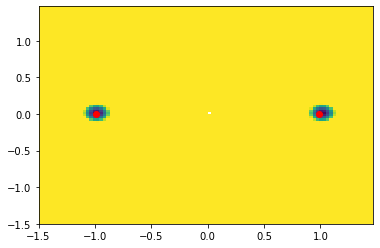

expected minima -2.2753352456842557
observed minima [4.76635732]


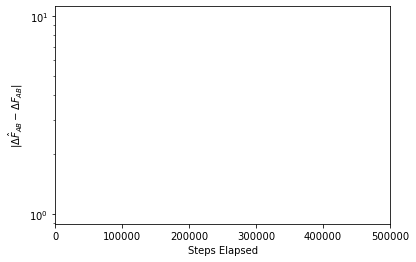

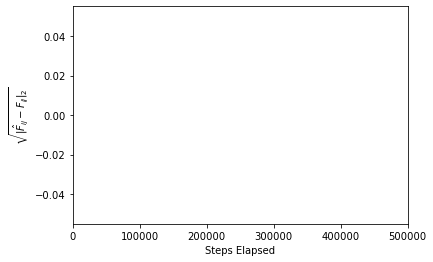

In [44]:
traj = dill.load(open("double_ring_well_traj_phys.pickle", "rb"))
AoI = AreaOfInterest(x_min=-1.5, x_max=1.5, y_min=-1.5, y_max=1.5, x_samples=100, y_samples=100)
ca = ConvergenceAnalyser(traj, ring_double_well_potential, AoI)
rmsd_anomaly, p, p_hat, weighted_estimate, weighted_actual, interpolated_grid, values = ca.plot_anomaly(plot_interval=5000)

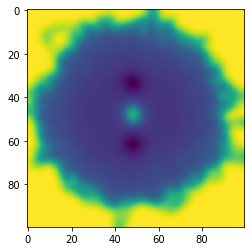

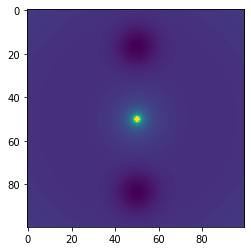

In [45]:
plt.imshow(interpolated_grid)
plt.show()
plt.imshow(values)

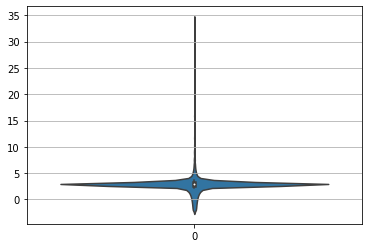

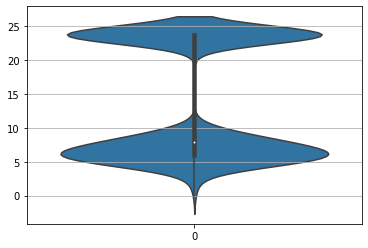

In [28]:
import seaborn as sns

df = pd.DataFrame(data=np.array([interpolated_grid.flatten(), values.flatten()]).T, columns=["est", "act"])
df.describe()

fig, axes = plt.subplots()
sns.violinplot(data=df.act, ax = axes)
axes.yaxis.grid(True)
plt.show()

fig, axes = plt.subplots()
sns.violinplot(data=df.est, ax = axes)
axes.yaxis.grid(True)
plt.show()

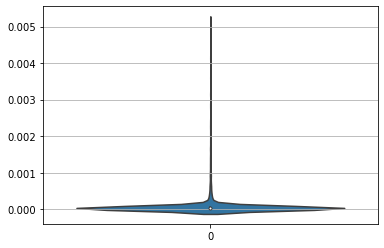

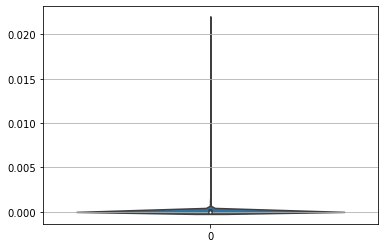

0.0


In [31]:
df = pd.DataFrame(data=np.array([p_hat.flatten(), p.flatten()]).T, columns=["est", "act"])


fig, axes = plt.subplots()
sns.violinplot(data=df.act, ax = axes)
axes.yaxis.grid(True)
plt.show()

fig, axes = plt.subplots()
sns.violinplot(data=df.est, ax = axes)
axes.yaxis.grid(True)
plt.show()

df.describe()

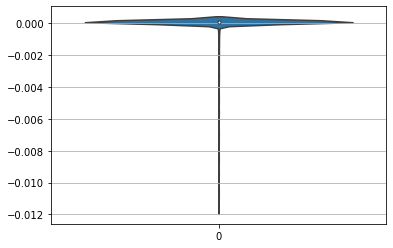

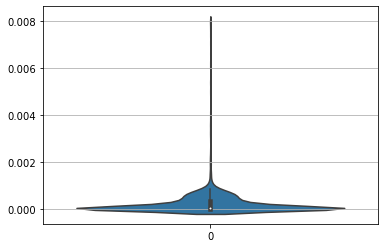

-0.053811970520845485
2.668854182493769


In [33]:
df = pd.DataFrame(data=np.array([weighted_estimate.flatten(), weighted_actual.flatten()]).T, columns=["est", "act"])
df.describe()


fig, axes = plt.subplots()
sns.violinplot(data=df.act, ax = axes)
axes.yaxis.grid(True)
plt.show()

fig, axes = plt.subplots()
sns.violinplot(data=df.est, ax = axes)
axes.yaxis.grid(True)
plt.show()

df.describe()

print(sum(df.act))
print(sum(df.est))